# Company Interlock workflow

In [2]:
import pandas as pd
import numpy as np

In [3]:
import pandas as pd
import numpy as np
from itertools import combinations

In [7]:
file_path = "../2.Initial_Graph_Building/boardex_us_companies_full_data_2022_2024.csv"

boardex_data = pd.read_csv(file_path, index_col = 0)

# Display the first few rows of the data to understand its structure
boardex_data.head()

,associationtype,boardname,companyname,directorname,overlapyearstart,overlapyearend,role,associatedrole,conncompanyorgtype,boardid,...,roletitle,roleboardposition,roleedflag,overlapyearstart_int,overlapyearend_int,startcompanydatestartrole,startcompanydateendrole,conncompanydatestartrole,conncompanydateendrole,orgtype
0,Unlisted Org,VERICEL CORP (Aastrom Biosciences Inc prior to...,Gladius Pharmaceuticals Inc,Doctor Steve Gilman,2020,Curr,Independent Director (Brd) (SD),Scientific Advisor (Non-Brd),Private,401.0,...,Independent Director,Brd,SD,2020,NaN,2015-01-06,NaN,NaN,NaN,Quoted
1,Unlisted Org,VERICEL CORP (Aastrom Biosciences Inc prior to...,ContraFect Corp,Doctor Steve Gilman,2023,Curr,Independent Director (Brd) (SD),Independent Vice Chairman (Brd) (SD),Private,401.0,...,Independent Director,Brd,SD,2023,NaN,2015-01-06,NaN,2023-11-09,NaN,Quoted
2,Other,VERICEL CORP (Aastrom Biosciences Inc prior to...,Northeastern University,Doctor Steve Gilman,2016,Curr,Independent Director (Brd) (SD),Advisory Board Member,Universities,401.0,...,Independent Director,Brd,SD,2016,NaN,2015-01-06,NaN,NaN,NaN,Quoted
3,Listed Org,VERICEL CORP (Aastrom Biosciences Inc prior to...,AKEBIA THERAPEUTICS INC,Doctor Steve Gilman,2018,Curr,Independent Director (Brd) (SD),Independent Director (Brd) (SD),Quoted,401.0,...,Independent Director,Brd,SD,2018,NaN,2015-01-06,NaN,2018-12-12,NaN,Quoted
4,Listed Org,VERICEL CORP (Aastrom Biosciences Inc prior to...,SCYNEXIS INC,Doctor Steve Gilman,2015,Curr,Independent Director (Brd) (SD),Independent Director (Brd) (SD),Quoted,401.0,...,Independent Director,Brd,SD,2015,NaN,2015-01-06,NaN,2015-02-25,NaN,Quoted


In [9]:
boardex_data.columns

Index(['associationtype', 'boardname', 'companyname', 'directorname',
       'overlapyearstart', 'overlapyearend', 'role', 'associatedrole',
       'conncompanyorgtype', 'boardid', 'companyid', 'directorid', 'roletitle',
       'roleboardposition', 'roleedflag', 'overlapyearstart_int',
       'overlapyearend_int', 'startcompanydatestartrole',
       'startcompanydateendrole', 'conncompanydatestartrole',
       'conncompanydateendrole', 'orgtype'],
      dtype='object')

Watch out for the column details here that's it

In [22]:
filtered_data = boardex_data[['boardid', 'companyid', 'directorid', 'overlapyearstart', 'overlapyearend' ]].drop_duplicates()

In [41]:
filtered_data['overlapyearend'].replace("Curr", 2024)
filtered_data['overlapyearend'] = pd.to_numeric(filtered_data['overlapyearend'], errors='coerce')

In [85]:
year = 2022

In [86]:
graph_simplified_df = filtered_data[ (year >= filtered_data['overlapyearstart']) & (year <= filtered_data['overlapyearend'])]

In [87]:
graph_simplified_df.columns

Index(['boardid', 'companyid', 'directorid', 'overlapyearstart',
       'overlapyearend'],
      dtype='object')

In [88]:
# Assuming graph_simplified_df is already loaded
# Step 1: Create a sorted unique company identifier
graph_simplified_df['company_pair'] = graph_simplified_df.apply(
    lambda row: '-'.join(sorted([str(row['boardid']), str(row['companyid'])])),
    axis=1
)  # 2-3 and 3-2 should be equivalent in graph_simplified_df['company']

# Ensure data uniqueness per director per company to avoid inflated pair counts
graph_simplified_df = graph_simplified_df.drop_duplicates(subset=['company_pair', 'directorid'])

# Step 2 & 3: Create combinations of directors for each company, only if there are at least two directors
director_pairs = graph_simplified_df.groupby('company_pair')['directorid'].apply(
    lambda x: pd.DataFrame(combinations(x.unique(), 2), columns=['Director1', 'Director2']) if len(x) > 1 else pd.DataFrame(columns=['Director1', 'Director2'])
).reset_index(drop=True)

# Step 4: Count occurrences of each pair
director_pairs = director_pairs.groupby(['Director1', 'Director2']).size().reset_index(name='weight')

# Step 5: Create the adjacency matrix
if not director_pairs.empty:
    directors = np.unique(director_pairs[['Director1', 'Director2']])
    adj_matrix = pd.DataFrame(np.zeros((len(directors), len(directors))), columns=directors, index=directors)

    # Populate the adjacency matrix
    for index, row in director_pairs.iterrows():
        adj_matrix.at[row['Director1'], row['Director2']] = row['weight']
        adj_matrix.at[row['Director2'], row['Director1']] = row['weight']

    # Ensure no self-loops
    np.fill_diagonal(adj_matrix.values, 0)

    print(adj_matrix)
else:
    print("No director pairs were found to have shared companies.")

/tmp/ipykernel_33932/1099311076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_simplified_df['company_pair'] = graph_simplified_df.apply(
/tmp/ipykernel_33932/1099311076.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  director_pairs = graph_simplified_df.groupby('company_pair')['directorid'].apply(


           1026.0     2415.0     3597.0     3637.0     8207.0     9499.0     \
1026.0           0.0        0.0        0.0        0.0        1.0        0.0   
2415.0           0.0        0.0        0.0        0.0        0.0        0.0   
3597.0           0.0        0.0        0.0        0.0        0.0        0.0   
3637.0           0.0        0.0        0.0        0.0        0.0        0.0   
8207.0           1.0        0.0        0.0        0.0        0.0        0.0   
...              ...        ...        ...        ...        ...        ...   
2704494.0        0.0        0.0        0.0        0.0        0.0        0.0   
2709141.0        0.0        0.0        0.0        0.0        0.0        0.0   
2709167.0        0.0        0.0        0.0        0.0        0.0        0.0   
2714293.0        0.0        0.0        0.0        0.0        0.0        0.0   
2777534.0        0.0        0.0        0.0        0.0        0.0        0.0   

           10075.0    10437.0    11536.0    13402.0

In [89]:
# # interestingly it is not actually that big so can run this easily.

# adj_matrix.to_csv("test_company_interlock_2024.csv")

We can see that the results are very sparse as seen here. Try the companies result here as well.

In [90]:
import networkx as nx

In [91]:
G = nx.from_pandas_adjacency(adj_matrix)
print(G)

Graph with 1694 nodes and 4611 edges


In [92]:
weights = [G[u][v]['weight'] for u, v in G.edges()]

In [93]:
max(weights) # 5 common directors so this is fine.

41.0

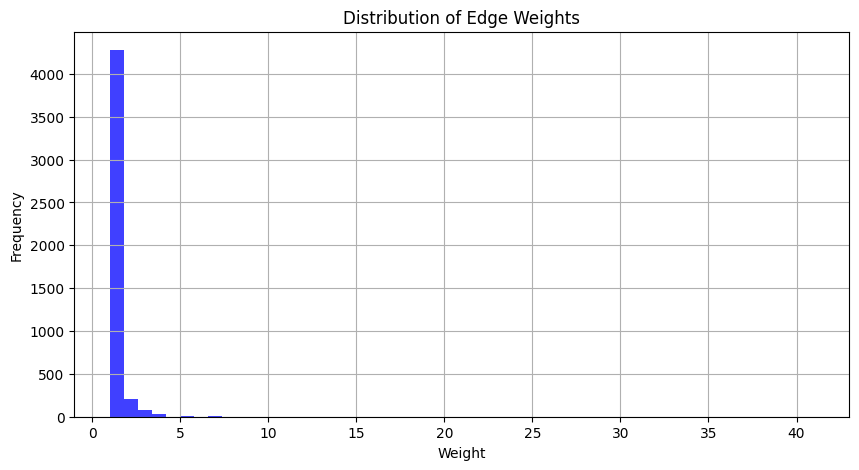

In [94]:
import matplotlib.pyplot as plt

# Histogram of the weights
plt.figure(figsize=(10, 5))
plt.hist(weights, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Removing the loss connection ones could be meaningful here, for workflow.

Maybe combine the results together, but just go with the binary approach here to see what could be useful.

In [80]:
density = nx.density(G)
print("Density of the graph:", density)

Density of the graph: 0.015770609318996417


In [81]:
clustering = nx.clustering(G)
print("Local clustering for each node:", clustering)


 # id details for each for director for this.

Local clustering for each node: {26765.0: 0.3333333333333333, 31557.0: 1.0, 31594.0: 0.6666666666666666, 31802.0: 0, 33748.0: 1.0, 41681.0: 0, 41891.0: 1.0, 48521.0: 0, 57277.0: 0, 61116.0: 0, 87037.0: 0, 104992.0: 1.0, 105362.0: 0, 106407.0: 0, 180469.0: 1.0, 182475.0: 0, 201098.0: 0.5, 201488.0: 0, 201508.0: 1.0, 204563.0: 0, 206687.0: 1.0, 272217.0: 0, 310066.0: 1.0, 320549.0: 0, 322648.0: 0, 322658.0: 1.0, 335958.0: 1.0, 336107.0: 0.2, 338381.0: 0, 339546.0: 0, 339859.0: 0, 341276.0: 0, 341907.0: 0, 342449.0: 0, 343430.0: 1.0, 346068.0: 1.0, 346277.0: 0, 347276.0: 0, 348858.0: 0, 371693.0: 0, 372478.0: 0.6666666666666666, 372501.0: 1.0, 373339.0: 0.6666666666666666, 377215.0: 1.0, 441789.0: 0, 443433.0: 0, 444520.0: 1.0, 448358.0: 0, 457742.0: 0, 457752.0: 1.0, 480648.0: 0, 481629.0: 0, 485929.0: 1.0, 486160.0: 0.3333333333333333, 493282.0: 0, 494019.0: 0, 495064.0: 0, 495186.0: 0, 496240.0: 0, 498672.0: 0, 500684.0: 0, 501540.0: 0, 502810.0: 0, 502817.0: 0, 502958.0: 0, 503068.0: 

In [82]:
degree_centrality = nx.degree_centrality(G)
print("Degree centrality for each node:", degree_centrality)


Degree centrality for each node: {26765.0: 0.010752688172043012, 31557.0: 0.007168458781362007, 31594.0: 0.010752688172043012, 31802.0: 0.0035842293906810036, 33748.0: 0.014336917562724014, 41681.0: 0.010752688172043012, 41891.0: 0.007168458781362007, 48521.0: 0.010752688172043012, 57277.0: 0.0035842293906810036, 61116.0: 0.007168458781362007, 87037.0: 0.0035842293906810036, 104992.0: 0.007168458781362007, 105362.0: 0.0035842293906810036, 106407.0: 0.0035842293906810036, 180469.0: 0.007168458781362007, 182475.0: 0.0035842293906810036, 201098.0: 0.014336917562724014, 201488.0: 0.0035842293906810036, 201508.0: 0.05734767025089606, 204563.0: 0.007168458781362007, 206687.0: 0.05734767025089606, 272217.0: 0.0035842293906810036, 310066.0: 0.007168458781362007, 320549.0: 0.0035842293906810036, 322648.0: 0.0035842293906810036, 322658.0: 0.010752688172043012, 335958.0: 0.06093189964157706, 336107.0: 0.017921146953405017, 338381.0: 0.0035842293906810036, 339546.0: 0.0035842293906810036, 339859.0

In [83]:
# more costly to run - this is quite costly as with community detection approaches

betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness centrality for each node:", betweenness_centrality)


Betweenness centrality for each node: {26765.0: 0.0007220030427271087, 31557.0: 0.0, 31594.0: 3.867873443180939e-05, 31802.0: 0.0, 33748.0: 0.0, 41681.0: 7.735746886361879e-05, 41891.0: 0.0, 48521.0: 7.735746886361879e-05, 57277.0: 0.0, 61116.0: 7.735746886361879e-05, 87037.0: 0.0, 104992.0: 0.0, 105362.0: 0.0, 106407.0: 0.0, 180469.0: 0.0, 182475.0: 0.0, 201098.0: 7.735746886361879e-05, 201488.0: 0.0, 201508.0: 0.0, 204563.0: 5.157164590907919e-05, 206687.0: 0.0, 272217.0: 0.0, 310066.0: 0.0, 320549.0: 0.0, 322648.0: 0.0, 322658.0: 0.0, 335958.0: 0.0, 336107.0: 0.00025785822954539595, 338381.0: 0.0, 339546.0: 0.0, 339859.0: 0.0, 341276.0: 0.0, 341907.0: 0.0, 342449.0: 0.0, 343430.0: 0.0, 346068.0: 0.0, 346277.0: 0.0, 347276.0: 7.735746886361879e-05, 348858.0: 0.0, 371693.0: 0.0, 372478.0: 1.2892911477269798e-05, 372501.0: 0.0, 373339.0: 2.5785822954539595e-05, 377215.0: 0.0, 441789.0: 0.0, 443433.0: 0.0, 444520.0: 0.0, 448358.0: 0.0, 457742.0: 0.0, 457752.0: 0.0, 480648.0: 0.0, 481629

In [52]:
# code is simpler

In [54]:
import matplotlib.pyplot as plt

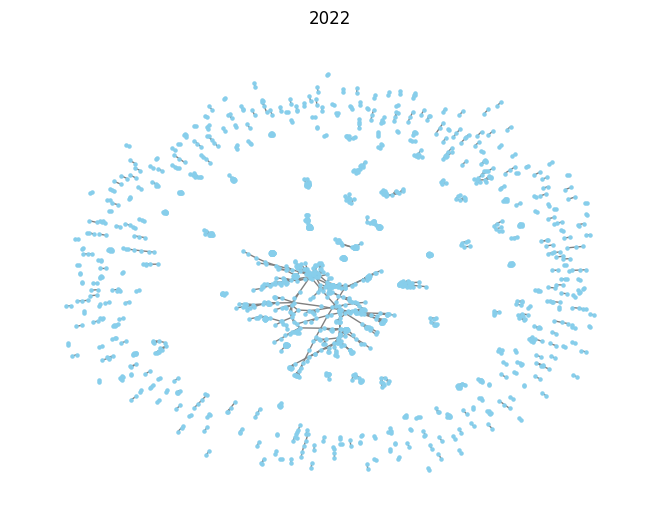

In [57]:
# Position nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=False, #with_labels=True, 
        node_color='skyblue', edge_color='gray', node_size=5, font_size=10)

# Show the plot
plt.title("2022")
plt.show()

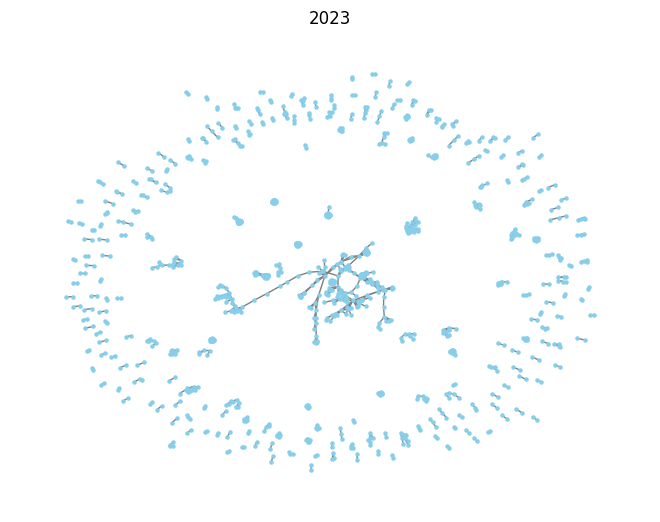

In [68]:
# Position nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=False, #with_labels=True, 
        node_color='skyblue', edge_color='gray', node_size=5, font_size=10)

# Show the plot
plt.title("2023")
plt.show()

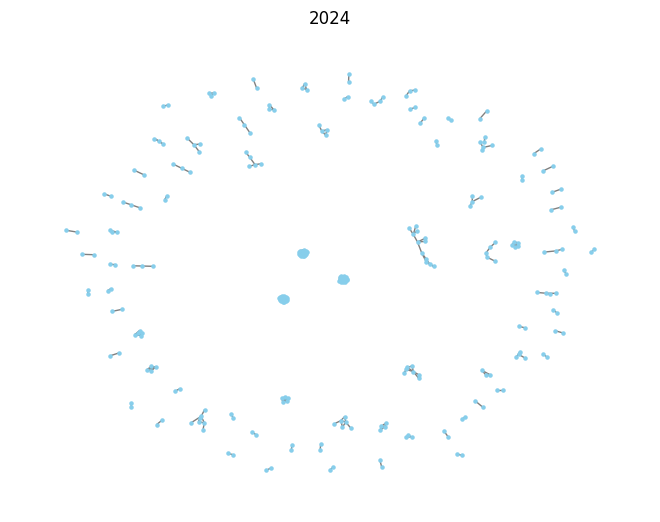

In [84]:
# Position nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=False, #with_labels=True, 
        node_color='skyblue', edge_color='gray', node_size=5, font_size=10)

# Show the plot
plt.title("2024")
plt.show()

Convert the code together for workflow later